In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: BlazingFire27
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 85.4MB/s]

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #since this is a binary problem, accuracy is enough
#in case of mmulticlass problem we should use precision and recall is better to use
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
#Basic Preprocessing the data

data_df.isna().sum()

,0
id,0
Area,0
MajorAxisLength,0
MinorAxisLength,0
Eccentricity,0
ConvexArea,0
EquivDiameter,0
Extent,0
Perimeter,0
Roundness,0


In [6]:
data_df.dropna(inplace= True)
data_df.drop(['id'], axis=1, inplace=True)
print(data_df.shape)

(18185, 11)


In [7]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [8]:
print(data_df['Class'].unique())
print(data_df['Class'].value_counts())

[1 0]
Class
1    9985
0    8200
Name: count, dtype: int64


In [9]:
#Normalization step of preprocessing data
#Divide each number by the largest number of the column

original_df = data_df.copy() #used for inferencing at the end

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

print(original_df.head())
print(data_df.head())

   Area  MajorAxisLength  MinorAxisLength  Eccentricity  ...  Perimeter  Roundness  AspectRation  Class
0  4537        92.229316        64.012769      0.719916  ...    273.085   0.764510      1.440796      1
1  2872        74.691881        51.400454      0.725553  ...    208.317   0.831658      1.453137      1
2  3048        76.293164        52.043491      0.731211  ...    210.012   0.868434      1.465950      1
3  3073        77.033628        51.928487      0.738639  ...    210.657   0.870203      1.483456      1
4  3693        85.124785        56.374021      0.749282  ...    230.332   0.874743      1.510000      1

[5 rows x 11 columns]
       Area  MajorAxisLength  MinorAxisLength  ...  Roundness  AspectRation  Class
0  0.444368         0.503404         0.775435  ...   0.844997      0.368316    1.0
1  0.281293         0.407681         0.622653  ...   0.919215      0.371471    1.0
2  0.298531         0.416421         0.630442  ...   0.959862      0.374747    1.0
3  0.300979         0

In [10]:
X = np.array(data_df.iloc[:, :-1]) #converting into numpy array for [all rows, all columns-lastcolumn]
Y = np.array(data_df.iloc[:, -1]) #converting into numpy array for [all rows, last column]

In [11]:
#spliting the datasets into train data, validation data and test data

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) #70% split

In [12]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5) #50% split

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(12729, 10)
(2728, 10)
(12729,)
(2728,)
(2728, 10)
(2728,)


In [15]:
#converting the data into pytorch format

class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device)
#converting X from datatype tuple/list/something to float32 tensor and then moving this modified X to device
    self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]


In [16]:
#creating objects for training, validation and testing

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [45]:
#model will calculate the weights, do the backpropagation etc
#for this we wont usually handle data one by one but in batches(batchsize is user defined)
#to go through a batchsize amount of data, we should create a dataloader
#a dataloader is basically an object we use to go through a for loop to loop through a specific amount of data in batches

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=32, shuffle=True)

In [46]:
for x,y in train_dataloader:
  print(x)
  print("======================")
  print(y)
  break
#note that batchsize=8 means 8 rows, 8 outputs
#see below that from X_train we got 8 rows full of numbers
#see below that for y_train we got 8 rows of 0s and 1s (the output column)

tensor([[0.6508, 0.8742, 0.6482, 0.9749, 0.6195, 0.8067, 0.8284, 0.7019, 0.7245,
         0.7652],
        [0.8675, 0.8432, 0.8934, 0.9089, 0.8234, 0.9314, 0.7732, 0.7407, 0.8670,
         0.5355],
        [0.8867, 0.8843, 0.8706, 0.9270, 0.8398, 0.9416, 0.6786, 0.7554, 0.8521,
         0.5763],
        [0.6803, 0.7620, 0.7822, 0.9171, 0.6422, 0.8248, 0.6603, 0.6567, 0.8652,
         0.5527],
        [0.8831, 0.8475, 0.9069, 0.9062, 0.8414, 0.9397, 0.8982, 0.7406, 0.8830,
         0.5301],
        [0.9640, 0.8636, 0.9671, 0.8930, 0.9174, 0.9818, 0.6962, 0.7668, 0.8990,
         0.5066],
        [0.8694, 0.8749, 0.8662, 0.9257, 0.8293, 0.9324, 0.6468, 0.7517, 0.8439,
         0.5730],
        [0.6577, 0.7467, 0.7644, 0.9178, 0.6224, 0.8110, 0.8030, 0.6426, 0.8734,
         0.5542],
        [0.6649, 0.8009, 0.7251, 0.9444, 0.6293, 0.8154, 0.7355, 0.6687, 0.8156,
         0.6267],
        [0.5632, 0.8152, 0.6096, 0.9739, 0.5379, 0.7504, 0.5266, 0.6476, 0.7363,
         0.7587],
        [0

In [47]:
#building the model

HIDDEN_NEURONS = 20
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.Linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.Linear(x)
    x = self.sigmoid(x)
    return x

#Straightforward flow of values,
#X goes inside input_layer and the output of the input layer goes inside the Linear Layer
#The output of the linear layer goes to the sigmoid layer(the output layer incase of binary classification)

model = MyModel().to(device)

In [48]:
#creating a summary to look at the model in a user friendly way

summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             220
            Linear-2                    [-1, 1]              21
           Sigmoid-3                    [-1, 1]               0
Total params: 241
Trainable params: 241
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [49]:
#creating loss and optimizer
criterion = nn.BCELoss() #critetia for loss = binary crossentropy loss
optimizer = Adam(model.parameters(), lr = 1e-3) #lr=learning rate

In [50]:
#interesting part
total_loss_train_plot = []
total_loss_validation_plot = []
total_accuracy_train_plot = []
total_accuracy_validation_plot = []

epochs = 10
for epoch in range(epochs):
  total_accuracy_train = 0
  total_loss_train = 0
  total_accuracy_validation = 0
  total_loss_validation = 0

  for data in train_dataloader:
    inputs, labels = data #inputs has 8 rows and labels has 8 labels

    prediction = model(inputs).squeeze(1)

    batch_loss = criterion(prediction, labels)
#prediction and labels should have same dimension for the BCE to apply on it

    total_loss_train += batch_loss.item()

#what have we done here
#first we have initialized the total_accurary_something = 0 for each epoch
#then we are taking a batch of 8 from the dataloader and
#then we are calculating batch_loss for that particular batch by predicting the values and using BCE
#then we are adding that batch_loss to total_loss in that epoch
#finally we will send that total_loss_per_epoch to total_loss_for_plotting
#then for a new epoch, we are calculating new total_loss_per_epoch by same manner

    acc = ((prediction).round() == labels).sum().item()
#item converts from tensor format to int format
#sum helps to calculate total number of True values

    total_accuracy_train += acc

#back prop to update the weights in case of training
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad() #better to use

# ==============================================================
  with torch.no_grad():

#use pytorch module not for training only for testing
#preparing the model for prediction only but not for training the weights

    for data in validation_dataloader:
      inputs, labels = data

      prediction = model(inputs).squeeze(1)

      batch_loss = criterion(prediction, labels)
      total_loss_validation += batch_loss.item()
      acc = ((prediction).round() == labels).sum().item()
      total_accuracy_validation += acc


#coming back to epoch level for loop
  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_validation/1000, 4))

  total_accuracy_train_plot.append(round(total_accuracy_train/training_data.__len__() * 100, 4))
  total_accuracy_validation_plot.append(round(total_accuracy_validation/validation_data.__len__() * 100, 4))

  print(f'''Epoch= {epoch+1}
            Train Loss= {round(total_loss_train/1000, 4)}
            Train Accuracy= {round(total_accuracy_train/training_data.__len__() * 100, 4)}
            Validation Loss= {round(total_loss_validation/1000, 4)}
            Validation Accuracy= {round(total_accuracy_validation/validation_data.__len__() * 100, 4)}
        ''')
  print("="*30)

Epoch= 1 
            Train Loss= 0.2235 
            Train Accuracy= 84.1621
            Validation Loss= 0.0325
            Validation Accuracy= 97.3974
        
Epoch= 2 
            Train Loss= 0.0947 
            Train Accuracy= 97.816
            Validation Loss= 0.0123
            Validation Accuracy= 98.2405
        
Epoch= 3 
            Train Loss= 0.0433 
            Train Accuracy= 98.3502
            Validation Loss= 0.0073
            Validation Accuracy= 98.9003
        
Epoch= 4 
            Train Loss= 0.029 
            Train Accuracy= 98.4681
            Validation Loss= 0.0053
            Validation Accuracy= 98.9736
        
Epoch= 5 
            Train Loss= 0.0232 
            Train Accuracy= 98.4916
            Validation Loss= 0.0045
            Validation Accuracy= 98.937
        
Epoch= 6 
            Train Loss= 0.0205 
            Train Accuracy= 98.5231
            Validation Loss= 0.0042
            Validation Accuracy= 98.937
        
Epoch= 7 
          

In [51]:
#testing part of our model

with torch.no_grad():
  total_loss_test = 0
  total_accuracy_test = 0

  for data in testing_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion(prediction, labels).item()
    total_loss_test += batch_loss_test

    acc = ((prediction.round() == labels)).sum().item()
    total_accuracy_test += acc

    print("Accuracy= ", round(total_accuracy_test/testing_data.__len__() * 100, 4))
  print("="*30)
  print("Accuracy= ", round(total_accuracy_test/testing_data.__len__() * 100, 4))

Accuracy=  1.173
Accuracy=  2.2727
Accuracy=  3.3724
Accuracy=  4.5088
Accuracy=  5.6818
Accuracy=  6.8548
Accuracy=  7.9912
Accuracy=  9.1642
Accuracy=  10.3006
Accuracy=  11.4736
Accuracy=  12.6466
Accuracy=  13.8196
Accuracy=  14.9927
Accuracy=  16.0924
Accuracy=  17.2287
Accuracy=  18.4018
Accuracy=  19.5748
Accuracy=  20.7111
Accuracy=  21.8842
Accuracy=  23.0205
Accuracy=  24.1935
Accuracy=  25.3666
Accuracy=  26.4663
Accuracy=  27.6026
Accuracy=  28.739
Accuracy=  29.912
Accuracy=  31.085
Accuracy=  32.2581
Accuracy=  33.4311
Accuracy=  34.6041
Accuracy=  35.7771
Accuracy=  36.9501
Accuracy=  38.0499
Accuracy=  39.1862
Accuracy=  40.3592
Accuracy=  41.4956
Accuracy=  42.6686
Accuracy=  43.8416
Accuracy=  44.978
Accuracy=  46.151
Accuracy=  47.2874
Accuracy=  48.4604
Accuracy=  49.5968
Accuracy=  50.7698
Accuracy=  51.9428
Accuracy=  53.1158
Accuracy=  54.2889
Accuracy=  55.3886
Accuracy=  56.5249
Accuracy=  57.6979
Accuracy=  58.8343
Accuracy=  59.9707
Accuracy=  61.1437
Accurac

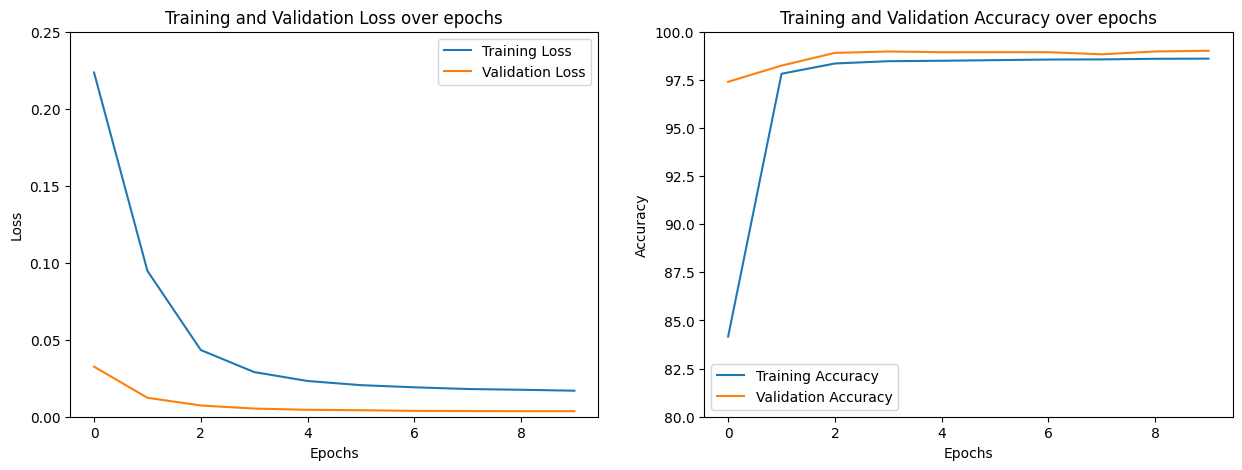

In [54]:
#visualization part

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation Loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,0.25])
axs[0].legend()

axs[1].plot(total_accuracy_train_plot, label = "Training Accuracy")
axs[1].plot(total_accuracy_validation_plot, label = "Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([80,100])
axs[1].legend()

plt.show()